In [1]:
import numpy as np
import torch
from torch import nn
from torch.autograd import Variable
from torchvision.datasets import ImageFolder
from torchvision import transforms

In [2]:
from test_utils import compute_log_likelihood_importance_sampling, compute_log_likelihood_monte_carlo, model_test_loss
from train_utils import train_model
from losses import gaussian_loss
from mask_generators import generate_rectangle, generate_mixture, generate_ones
from nn_utils import MemData, Reshape, MergeSkipConnection, AddSkipConnection, ResNetBlock
from UCM import UCM

In [3]:
import os
import shutil

In [4]:
celeba_prefix = '/data/datasets/CelebA'
if not os.path.exists(os.path.join(celeba_prefix, 'Img', 'img_align_celeba')):
    raise Exception('Please download CelebA and unzip img_align_celeba.zip into Img/img_align_celeba.')
if not os.path.exists(os.path.join(celeba_prefix, 'Eval', 'list_eval_partition.txt')):
    raise Exception('Please download CelebA and place list_eval_partition.txt into Eval.')

In [5]:
def prepare_data(path, copy=False):
    old_path = os.getcwd()
    os.chdir(path)

    if os.path.exists('splitted'):
        shutil.rmtree('splitted')
    os.mkdir('splitted')
    split = {
        '0': 'train',
        '1': 'valid', 
        '2': 'test'
    }
    for name in split.values():
        os.mkdir(os.path.join('splitted', name))
        os.mkdir(os.path.join('splitted', name, '0'))

    for line in open(os.path.join('Eval', 'list_eval_partition.txt')):
        if not line.strip():
            continue
        filename, part = line.strip().split(' ')
        src, dst = os.path.join('..', '..', '..', 'Img', 'img_align_celeba', filename), filename
        os.chdir(os.path.join('splitted', split[part], '0'))
        if copy:
            shutil.copyfile(src, dst)
        else:
            os.link(src, dst)
        os.chdir(os.path.join('..', '..', '..'))
    os.chdir(old_path)

In [6]:
prepare_data(celeba_prefix)

In [7]:
transform = transforms.Compose([
    transforms.CenterCrop(160),
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])
train_data = ImageFolder(os.path.join(celeba_prefix, 'splitted', 'train'), transform=transform)
valid_data = ImageFolder(os.path.join(celeba_prefix, 'splitted', 'valid'), transform=transform)
test_data = ImageFolder(os.path.join(celeba_prefix, 'splitted', 'test'), transform=transform)

In [8]:
from matplotlib import pyplot as plt
%matplotlib inline

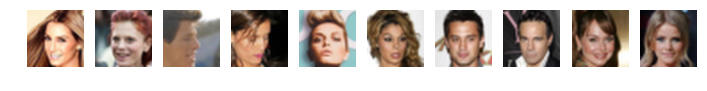

In [9]:
from matplotlib import pyplot as plt
%matplotlib inline

def show_images(x):
    plt.figure(figsize=(12, 12 / 10 * (x.shape[0] // 10 + 1)))
    x = x.view(-1, 3, 32, 32)
    for i in range(x.shape[0]):
        plt.subplot(x.shape[0] // 10 + 1, 10, i + 1)
        plt.imshow(x.data[i].numpy().swapaxes(0, 1).swapaxes(1, 2) * 0.5 + 0.5, cmap='Greys_r',
                   vmin=0, vmax=1, interpolation='lanczos')
        plt.axis('off')

show_images(Variable(torch.cat([train_data[i][0].view(-1, 3, 32, 32) for i in range(10)], 0)))

In [10]:
def generate_rectangle_CelebA(batch_size):
    def reject(x1, y1, x2, y2):
        return (x2 - x1 + 1) * (y2 - y1 + 1) < 32 * 32 // 4
    return generate_mixture(batch_size, [
        lambda sz: generate_rectangle(sz, 32, 32, reject),
        lambda sz: generate_ones(sz, 32 * 32 * 3)
    ], [19, 1])

In [11]:
d = 32
width = 32

In [12]:
skip_connection_0 = MemData()
skip_connection_1 = MemData()
skip_connection_2 = MemData()
skip_connection_3 = MemData()
skip_connection_4 = MemData()
proposal_network = nn.Sequential(
    Reshape(6, 32, 32),
    ResNetBlock(6, width),
    ResNetBlock(width, width * 2, 2),
    ResNetBlock(width * 2, width * 2),
    ResNetBlock(width * 2, width * 4, 2),
    ResNetBlock(width * 4, width * 4),
    ResNetBlock(width * 4, width * 8, 2),
    ResNetBlock(width * 8, width * 8),
    ResNetBlock(width * 8, width * 16, 2),
    Reshape(-1),
)
proposal_mu_head = nn.Linear(width * 16 * 2 * 2, d)
proposal_sigma_head = nn.Linear(width * 16 * 2 * 2, d)
prior_network = nn.Sequential(
    Reshape(6, 32, 32),
    skip_connection_0,
    ResNetBlock(6, width),
    ResNetBlock(width, width * 2, 2),
    skip_connection_1,
    ResNetBlock(width * 2, width * 2),
    ResNetBlock(width * 2, width * 4, 2),
    skip_connection_2,
    ResNetBlock(width * 4, width * 4),
    ResNetBlock(width * 4, width * 8, 2),
    skip_connection_3,
    ResNetBlock(width * 8, width * 8),
    ResNetBlock(width * 8, width * 16, 2),
    skip_connection_4,
    Reshape(-1),
)
prior_mu_head = nn.Linear(width * 16 * 2 * 2, d)
prior_sigma_head = nn.Linear(width * 16 * 2 * 2, d)
generative_network = nn.Sequential(
    nn.Linear(d, width * 16 * 2 * 2),
    nn.LeakyReLU(),
    Reshape(width * 16, 2, 2),
    MergeSkipConnection(skip_connection_4),
    nn.Upsample(scale_factor=2),
    ResNetBlock(width * 16 + width * 16, width * 8),
    ResNetBlock(width * 8, width * 8),
    MergeSkipConnection(skip_connection_3),
    nn.Upsample(scale_factor=2),
    ResNetBlock(width * 8 + width * 8, width * 4),
    ResNetBlock(width * 4, width * 4),
    MergeSkipConnection(skip_connection_2),
    nn.Upsample(scale_factor=2),
    ResNetBlock(width * 4 + width * 4, width * 2),
    ResNetBlock(width * 2, width * 2),
    MergeSkipConnection(skip_connection_1),
    nn.Upsample(scale_factor=2),
    MergeSkipConnection(skip_connection_0),
    ResNetBlock(width * 2 + width * 2 + 6, width, batchnorm=False, bias=True),
    ResNetBlock(width, width, batchnorm=False, bias=True),
    nn.Conv2d(width, 6, 3, 1, 1),
    Reshape(-1)
)

In [13]:
ucm_tests = [
    {
        'name': 'MC',
        'func': lambda model:
                model_test_loss(test_data, generate_rectangle_CelebA,
                                lambda batch, mask:
                                    compute_log_likelihood_monte_carlo(batch, mask, model,
                                                                       gaussian_loss, K=10),
                                is_cuda = True,
                                max_batches=40,
                                batch_size=32,
                                num_workers=4
                               )
    },
    {
        'name': 'IS',
        'func': lambda model:
                model_test_loss(test_data, generate_rectangle_CelebA,
                                lambda batch, mask:
                                    compute_log_likelihood_importance_sampling(batch, mask, model,
                                                                               gaussian_loss, K=10),
                                is_cuda = True,
                                max_batches=40,
                                batch_size=32,
                                num_workers=4
                               )
    }
]

In [14]:
model = UCM(1, gaussian_loss,
        proposal_network, proposal_mu_head, proposal_sigma_head,
        prior_network, prior_mu_head, prior_sigma_head,
        generative_network)

In [15]:
%%time
for i in range(len(train_data)):
    j = train_data[i]
    if i % 1000 == 0:
        print('\rTouching files to put them into disk cache:', i, 'of', len(train_data), end='')
print()

Touching files to put them into disk cache: 162000 of 162770
CPU times: user 2min 43s, sys: 3.01 s, total: 2min 47s
Wall time: 2min 47s


In [16]:
%time model_a1 = train_model(train_data, model, generate_rectangle_CelebA, \
                             tests=ucm_tests, batch_size=64, test_freq=200, \
                             num_epochs=10, learning_rate=5e-4, \
                             verbose_update_freq=5, num_workers=4)

Epoch 0 Train loss -519.4351806640625 Batch 2544 of 2544            
Epoch 1 Train loss -209.27755737304688 Batch 2544 of 2544           
Epoch 2 Train loss -311.3373718261719 Batch 201 of 2544            

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f57a8699cc0>>
Traceback (most recent call last):
  File "/home/oleg/soft/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 349, in __del__
    self._shutdown_workers()
  File "/home/oleg/soft/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 328, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/oleg/soft/anaconda3/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/oleg/soft/anaconda3/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 70, in rebuild_storage_fd
    fd = df.detach()
  File "/home/oleg/soft/anaconda3/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/oleg/soft/anaconda3/lib/python3.6/multiprocessing/resource_shar

Epoch 2 Train loss -82.42546081542969 Batch 2544 of 2544            
Epoch 3 Train loss -543.7882690429688 Batch 2544 of 2544            
Epoch 4 Train loss -369.2097473144531 Batch 2544 of 2544            
Epoch 5 Train loss -25.8559513092041 Batch 2544 of 2544             
Epoch 6 Train loss -231.52850341796875 Batch 2544 of 2544           
Epoch 7 Train loss -20.852596282958984 Batch 601 of 2544           

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f57a40e5d68>>
Traceback (most recent call last):
  File "/home/oleg/soft/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 349, in __del__
    self._shutdown_workers()
  File "/home/oleg/soft/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 328, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/oleg/soft/anaconda3/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/oleg/soft/anaconda3/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 70, in rebuild_storage_fd
    fd = df.detach()
  File "/home/oleg/soft/anaconda3/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/oleg/soft/anaconda3/lib/python3.6/multiprocessing/resource_shar

Epoch 7 Train loss -185.3019561767578 Batch 2544 of 2544             
Epoch 8 Train loss -197.14990234375 Batch 2544 of 2544              
Epoch 9 Train loss -96.7503662109375 Batch 2544 of 2544               
CPU times: user 1h 28min 17s, sys: 23min 51s, total: 1h 52min 9s
Wall time: 1h 38min 55s


In [17]:
s = model_a1['model'].state_dict()
import pickle as pkl
with open('celeba_small.weights', 'wb') as f:
    pkl.dump(s, f)
with open('celeba_small.debug_info', 'wb') as f:
    pkl.dump({
        'train_losses_list': model_a1['train_losses_list'],
        'test_results': model_a1['test_results']
    }, f)

In [18]:
import pickle as pkl
model = UCM(1, gaussian_loss,
        proposal_network, proposal_mu_head, proposal_sigma_head,
        prior_network, prior_mu_head, prior_sigma_head,
        generative_network)
with open('celeba_small.weights', 'rb') as f:
    s = pkl.load(f)
with open('celeba_small.debug_info', 'rb') as f:
    model_a1 = pkl.load(f)
model.load_state_dict(s)
model_a1['model'] = model

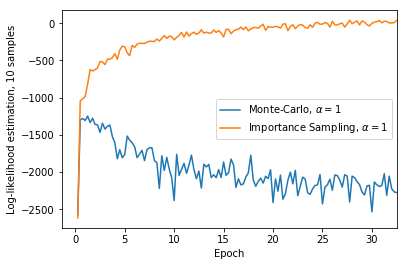

In [19]:
for label, name, model_dict in [
    (r'Monte-Carlo, $\alpha=1$', 'MC', model_a1),
    (r'Importance Sampling, $\alpha=1$', 'IS', model_a1),
]:
    data = [x[name] for x in model_dict['test_results']]
    x_labels = (1 + np.arange(len(data))) / 4
    plt.plot(x_labels, data, label=label)
plt.xlabel('Epoch')
plt.xlim(xmax=x_labels[-1])
plt.ylabel('Log-likelihood estimation, 10 samples')
plt.legend()

In [20]:
def average(func, K=5):
    res = []
    for i in range(K):
        res.append(func())
    res = torch.Tensor(res)
    return res.mean(), res.std()

In [21]:
mc_1000 = lambda: \
    model_test_loss(test_data, generate_rectangle_CelebA,
                    lambda batch, b:    compute_log_likelihood_monte_carlo(batch, b,
                                                                           model_a1['model'].cuda(),
                                                                           gaussian_loss, K=1000),
                    is_cuda=True,
                    batch_size=1,
                    max_batches=100)
mc_100 = lambda: \
    model_test_loss(test_data, generate_rectangle_CelebA,
                    lambda batch, b:    compute_log_likelihood_monte_carlo(batch, b,
                                                                           model_a1['model'].cuda(),
                                                                           gaussian_loss, K=100),
                    is_cuda=True,
                    batch_size=1,
                    max_batches=100)
is_100 = lambda: \
    model_test_loss(test_data, generate_rectangle_CelebA,
                    lambda batch, b:    compute_log_likelihood_importance_sampling(batch, b,
                                                                                   model_a1['model'].cuda(),
                                                                                   gaussian_loss, K=100),
                    is_cuda=True,
                    batch_size=1,
                    max_batches=100)

In [22]:
%time print('%f \pm %f' % average(mc_1000))

-913.350586 \pm 35.029144
CPU times: user 1min 43s, sys: 51.6 s, total: 2min 34s
Wall time: 2min 34s


In [23]:
%time print('%f \pm %f' % average(mc_100))

-1195.569702 \pm 155.295166
CPU times: user 12.8 s, sys: 3.53 s, total: 16.4 s
Wall time: 16.4 s


In [24]:
%time print('%f \pm %f' % average(is_100))

59.995461 \pm 14.998011
CPU times: user 14.5 s, sys: 3.63 s, total: 18.2 s
Wall time: 18.2 s


In [25]:
model_a1['model'].cpu()
pass

In [26]:
model.cpu()
pass

In [27]:
def draw_sample(img):
    plt.imshow(np.clip(img.reshape(3, 32, 32).swapaxes(0, 1).swapaxes(1, 2) * 0.5 + 0.5, 0, 1),
               cmap='Greys_r', vmin=0, vmax=1, interpolation='bilinear')
    plt.axis('off')

In [28]:
def test_sample(img0, mask0, model, K):
    img = img0.view(1, -1)
    mask = mask0.view(1, -1)
    res = {}
    res['input'] = (img0.view(1, -1) * (1 - mask)).view(3, 32, 32).numpy()
    res['groundtruth'] = img0.view(3, 32, 32).numpy()
    res['results'] = (model.generate_samples(img, mask, K).numpy()[:, :, :3 * 32 * 32] * mask.view(1, 1, 3 * 32 * 32) + \
                ((1 - mask) * img).view(1, 1, 3 * 32 * 32)).view(-1, 3, 32, 32).numpy()
    return res

In [29]:
np.random.seed(239)
res = []
for i in range(10):
    a = test_data[np.random.randint(0, len(test_data.samples) - 1)][0].view(1, -1)
    while True:
        b = generate_rectangle_CelebA(1)
        if not np.all(b == 1):
            break
    lres = test_sample(a, b, model, 10)
    res.append(lres)

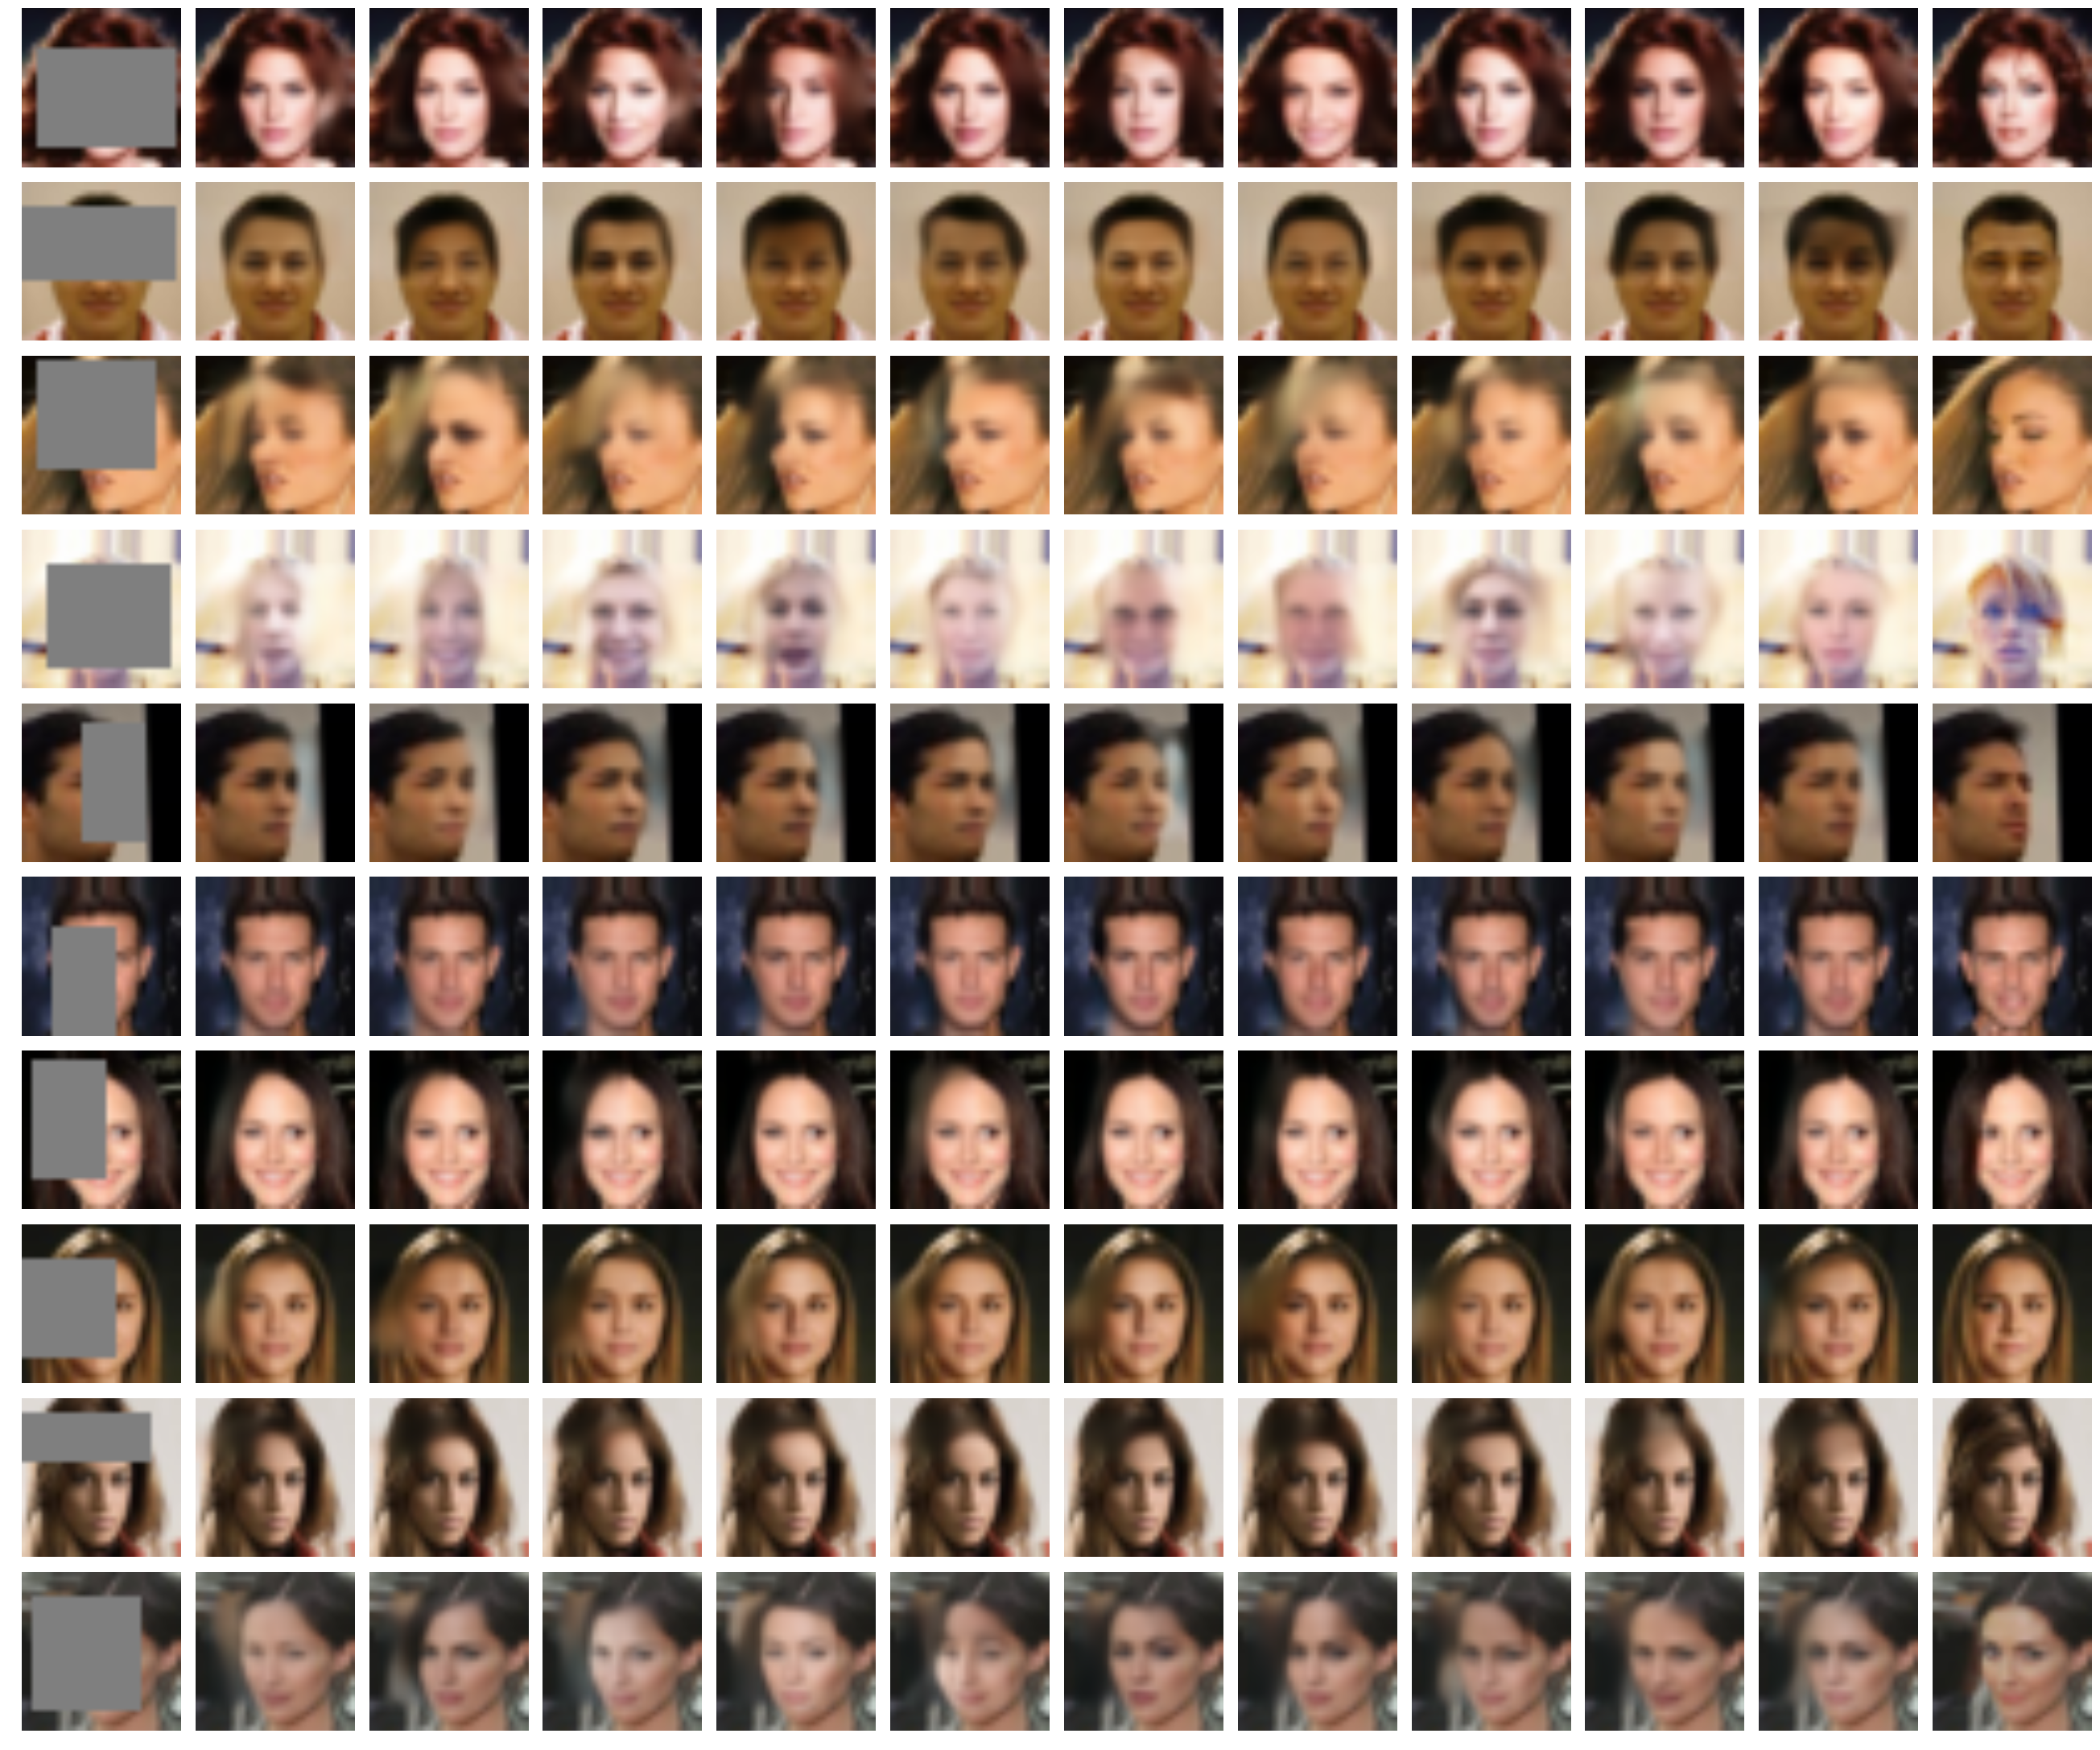

In [30]:
s = 3
n = 10
plt.figure(figsize=((n + 2) * s, s * len(res)))
for i in range(len(res)):
    plt.subplot(len(res), (n + 2), i * (n + 2) + 1)
    draw_sample(res[i]['input'])
    for j in range(n):
        plt.subplot(len(res), (n + 2), i * (n + 2) + j + 2)
        draw_sample(res[i]['results'][j])
    plt.subplot(len(res), (n + 2), i * (n + 2) + n + 2)
    draw_sample(res[i]['groundtruth'])
plt.tight_layout(pad=0, w_pad=-0.2, h_pad=-0.2)
plt.savefig('celeba_small.pdf', bbox_inches='tight')